# Analyse réseau

In [1]:
from scapy.all import *
import pandas as pd


capture1 :
    protocole : 

capture2 :
    protocole : 

# Read

In [2]:
def read_pcap(file_path):
    packets = rdpcap(file_path)
    print(f"Nombre total de paquets dans {file_path}: {len(packets)}")

    return packets

In [3]:
# Lire le fichier pcap
capture1 = read_pcap("capture 1.pcapng")
capture2 = read_pcap("capture 2.pcapng")

Nombre total de paquets dans capture 1.pcapng: 100930
Nombre total de paquets dans capture 2.pcapng: 317593


In [4]:
anomalies_capture1 = read_pcap("anomalies1.pcapng")
anomalies_capture2 = read_pcap("anomalies2.pcapng")

Nombre total de paquets dans anomalies1.pcapng: 739
Nombre total de paquets dans anomalies2.pcapng: 29551


## Create DF

### Information de chaque paquet

In [5]:
def extract_packet_info(packets):
    # Initialize lists to store packet information
    src_ip_list = []
    dst_ip_list = []
    src_port_list = []
    dst_port_list = []
    protocol_list = []
    packet_size_list = []
    time_delta_list = []
    packet_type_list = []

    # Extract packet information
    prev_packet_time = None
    for packet in packets:
        # Extract source and destination IP addresses
        src_ip = packet[IP].src if IP in packet else None
        dst_ip = packet[IP].dst if IP in packet else None

        # Extract source and destination ports if available
        if IP in packet:
            src_port = packet[IP].sport if hasattr(packet[IP], 'sport') else None
            dst_port = packet[IP].dport if hasattr(packet[IP], 'dport') else None
        else:
            src_port, dst_port = None, None

        # Extract transport layer protocol if available
        protocol = packet[IP].proto if IP in packet else None

        # Extract packet size
        packet_size = len(packet)

        # Calculate time delta (time elapsed since the previous packet)
        current_packet_time = packet.time
        time_delta = current_packet_time - prev_packet_time if prev_packet_time else None
        prev_packet_time = current_packet_time

        # Extract packet type (data or control packet)
        packet_type = "Data" if packet.haslayer(Raw) else "Control"


        # Append extracted information and error status to lists
        src_ip_list.append(src_ip)
        dst_ip_list.append(dst_ip)
        src_port_list.append(src_port)
        dst_port_list.append(dst_port)
        protocol_list.append(protocol)
        packet_size_list.append(packet_size)
        time_delta_list.append(time_delta)
        packet_type_list.append(packet_type)

    # Create a DataFrame from the lists
    packet_df = pd.DataFrame({
        'Source_IP': src_ip_list,
        'Destination_IP': dst_ip_list,
        'Source_Port': src_port_list,
        'Destination_Port': dst_port_list,
        'Protocol': protocol_list,
        'Packet_Size': packet_size_list,
        'Time_Delta': time_delta_list,
        'Packet_Type': packet_type_list,
    })

    return packet_df


In [6]:
capture1_df = extract_packet_info(capture1)
capture1_df.head()

,Source_IP,Destination_IP,Source_Port,Destination_Port,Protocol,Packet_Size,Time_Delta,Packet_Type
0,172.18.226.121,192.168.229.51,52255.0,10443.0,6.0,60,None,Control
1,172.18.226.121,192.168.229.51,52255.0,10443.0,6.0,124,0.000332,Data
2,192.168.229.51,172.18.226.121,4500.0,64916.0,17.0,146,0.000002,Control
3,172.18.226.121,192.168.229.51,52255.0,10443.0,6.0,124,0.000159,Data
4,172.18.226.121,192.168.229.51,52255.0,10443.0,6.0,134,0.000002,Data


In [7]:
capture1_df.shape

(100930, 8)

In [8]:
capture2_df = extract_packet_info(capture2)
capture2_df.head()

,Source_IP,Destination_IP,Source_Port,Destination_Port,Protocol,Packet_Size,Time_Delta,Packet_Type
0,40.115.19.176,10.200.0.130,443.0,53841.0,6.0,60,None,Control
1,40.115.19.176,10.200.0.130,443.0,53841.0,6.0,60,0.000004,Control
2,10.200.0.130,40.115.19.176,53841.0,443.0,6.0,60,0.000001,Control
3,5.249.120.14,10.200.0.130,10650.0,4500.0,17.0,166,0.000001,Control
4,10.200.0.130,5.249.120.14,4500.0,10650.0,17.0,118,0.000001,Control


### Anomalies

In [9]:

anomalies_capture1_df = extract_packet_info(anomalies_capture1)


In [10]:
anomalies_capture1_df.head()

,Source_IP,Destination_IP,Source_Port,Destination_Port,Protocol,Packet_Size,Time_Delta,Packet_Type
0,172.20.1.154,239.255.255.250,54094.0,1900.0,17.0,216,None,Data
1,172.18.226.121,192.168.229.51,52255.0,10443.0,6.0,66,0.659880,Control
2,172.18.226.121,192.168.229.51,52255.0,10443.0,6.0,66,0.000000,Control
3,172.18.226.121,192.168.229.51,52255.0,10443.0,6.0,66,0.000000,Control
4,172.18.226.121,192.168.229.51,52255.0,10443.0,6.0,66,0.000819,Control


In [11]:
anomalies_capture2_df = extract_packet_info(anomalies_capture2)
anomalies_capture2_df.head()

,Source_IP,Destination_IP,Source_Port,Destination_Port,Protocol,Packet_Size,Time_Delta,Packet_Type
0,5.249.120.14,10.200.0.130,10650.0,4500.0,17.0,258,None,Control
1,5.249.120.14,10.200.0.130,10650.0,4500.0,17.0,118,0.023162,Control
2,5.249.120.14,10.200.0.130,10650.0,4500.0,17.0,226,0.012319,Control
3,5.249.120.14,10.200.0.130,10650.0,4500.0,17.0,118,0.004757,Control
4,5.249.120.14,10.200.0.130,10650.0,4500.0,17.0,374,0.014341,Control


### Create final df

In [12]:
capture1_df.shape

(100930, 8)

In [30]:
# Count the number of duplicate rows
num_duplicates = capture1_df.duplicated().sum()

print("Number of duplicate rows:", num_duplicates)


Number of duplicate rows: 79474


In [13]:
anomalies_capture1_df.shape

(739, 8)

In [31]:
# Count the number of duplicate rows
num_duplicates = anomalies_capture1_df.duplicated().sum()

print("Number of duplicate rows:", num_duplicates)


Number of duplicate rows: 246


In [14]:
capture1_df.head()

,Source_IP,Destination_IP,Source_Port,Destination_Port,Protocol,Packet_Size,Time_Delta,Packet_Type
0,172.18.226.121,192.168.229.51,52255.0,10443.0,6.0,60,None,Control
1,172.18.226.121,192.168.229.51,52255.0,10443.0,6.0,124,0.000332,Data
2,192.168.229.51,172.18.226.121,4500.0,64916.0,17.0,146,0.000002,Control
3,172.18.226.121,192.168.229.51,52255.0,10443.0,6.0,124,0.000159,Data
4,172.18.226.121,192.168.229.51,52255.0,10443.0,6.0,134,0.000002,Data


In [15]:
anomalies_capture1_df.head()

,Source_IP,Destination_IP,Source_Port,Destination_Port,Protocol,Packet_Size,Time_Delta,Packet_Type
0,172.20.1.154,239.255.255.250,54094.0,1900.0,17.0,216,None,Data
1,172.18.226.121,192.168.229.51,52255.0,10443.0,6.0,66,0.659880,Control
2,172.18.226.121,192.168.229.51,52255.0,10443.0,6.0,66,0.000000,Control
3,172.18.226.121,192.168.229.51,52255.0,10443.0,6.0,66,0.000000,Control
4,172.18.226.121,192.168.229.51,52255.0,10443.0,6.0,66,0.000819,Control


In [16]:
# Convert all 'EDecimal' columns in capture1_df to float
capture1_ed_columns = capture1_df.applymap(lambda x: isinstance(x, decimal.Decimal)).any()
for col in capture1_df.columns[capture1_ed_columns]:
    capture1_df[col] = capture1_df[col].apply(lambda x: float(x) if isinstance(x, decimal.Decimal) else x)

# Convert all 'EDecimal' columns in anomalies_capture1_df to float
anomalies_ed_columns = anomalies_capture1_df.applymap(lambda x: isinstance(x, decimal.Decimal)).any()
for col in anomalies_capture1_df.columns[anomalies_ed_columns]:
    anomalies_capture1_df[col] = anomalies_capture1_df[col].apply(lambda x: float(x) if isinstance(x, decimal.Decimal) else x)

test_df = capture1_df.merge(anomalies_capture1_df,
                              on=['Source_IP', 'Destination_IP', 'Source_Port', 'Destination_Port', 'Protocol', 'Packet_Size', 'Time_Delta', 'Packet_Type'],
                              how='left',
                              indicator=True)

test_df['anomalie'] = test_df['_merge'].apply(lambda x: 1 if x == 'both' else 0)
test_df = test_df.drop(columns='_merge')


C:\Users\idris\AppData\Local\Temp\ipykernel_12040\1376692372.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  capture1_ed_columns = capture1_df.applymap(lambda x: isinstance(x, decimal.Decimal)).any()
C:\Users\idris\AppData\Local\Temp\ipykernel_12040\1376692372.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  anomalies_ed_columns = anomalies_capture1_df.applymap(lambda x: isinstance(x, decimal.Decimal)).any()


In [17]:
test_df.head()

,Source_IP,Destination_IP,Source_Port,Destination_Port,Protocol,Packet_Size,Time_Delta,Packet_Type,anomalie
0,172.18.226.121,192.168.229.51,52255.0,10443.0,6.0,60,NaN,Control,0
1,172.18.226.121,192.168.229.51,52255.0,10443.0,6.0,124,0.000332,Data,0
2,192.168.229.51,172.18.226.121,4500.0,64916.0,17.0,146,0.000002,Control,1
3,172.18.226.121,192.168.229.51,52255.0,10443.0,6.0,124,0.000159,Data,0
4,172.18.226.121,192.168.229.51,52255.0,10443.0,6.0,134,0.000002,Data,0


In [29]:
test_df.shape

(321270, 9)

In [18]:
test_df['anomalie'].value_counts()

anomalie
1    241166
0     80104
Name: count, dtype: int64

In [28]:
# Count the number of duplicate rows
num_duplicates = test_df.duplicated().sum()

print("Number of duplicate rows:", num_duplicates)


Number of duplicate rows: 299814


In [19]:
# Convert all 'EDecimal' columns in capture1_df to float
capture2_ed_columns = capture2_df.applymap(lambda x: isinstance(x, decimal.Decimal)).any()
for col in capture2_df.columns[capture2_ed_columns]:
    capture2_df[col] = capture2_df[col].apply(lambda x: float(x) if isinstance(x, decimal.Decimal) else x)

# Convert all 'EDecimal' columns in anomalies_capture1_df to float
anomalies_ed_columns = anomalies_capture2_df.applymap(lambda x: isinstance(x, decimal.Decimal)).any()
for col in anomalies_capture2_df.columns[anomalies_ed_columns]:
    anomalies_capture2_df[col] = anomalies_capture2_df[col].apply(lambda x: float(x) if isinstance(x, decimal.Decimal) else x)


train_df = capture2_df.merge(anomalies_capture2_df,
                              on=['Source_IP', 'Destination_IP', 'Source_Port', 'Destination_Port', 'Protocol', 'Packet_Size', 'Time_Delta', 'Packet_Type'],
                              how='left',
                              indicator=True)

train_df['anomalie'] = train_df['_merge'].apply(lambda x: 1 if x == 'both' else 0)
train_df = train_df.drop(columns='_merge')



C:\Users\idris\AppData\Local\Temp\ipykernel_12040\2563157806.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  capture2_ed_columns = capture2_df.applymap(lambda x: isinstance(x, decimal.Decimal)).any()


C:\Users\idris\AppData\Local\Temp\ipykernel_12040\2563157806.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  anomalies_ed_columns = anomalies_capture2_df.applymap(lambda x: isinstance(x, decimal.Decimal)).any()


In [20]:
train_df['anomalie'].value_counts()

anomalie
1    494064
0    287463
Name: count, dtype: int64

In [32]:
train_df.head()

,Source_IP,Destination_IP,Source_Port,Destination_Port,Protocol,Packet_Size,Time_Delta,Packet_Type,anomalie
0,40.115.19.176,10.200.0.130,443.0,53841.0,6.0,60,NaN,Control,0
1,40.115.19.176,10.200.0.130,443.0,53841.0,6.0,60,0.000004,Control,0
2,10.200.0.130,40.115.19.176,53841.0,443.0,6.0,60,0.000001,Control,0
3,5.249.120.14,10.200.0.130,10650.0,4500.0,17.0,166,0.000001,Control,1
4,5.249.120.14,10.200.0.130,10650.0,4500.0,17.0,166,0.000001,Control,1


### information de session

In [33]:
def analyze_session(packet_df):
    # Group packets by session
    session_info = {}
    sessions = packet_df.groupby(['Source_IP', 'Destination_IP', 'Source_Port', 'Destination_Port', 'Protocol'])
    
    # Iterate over each session
    for session, packets in sessions:
        # Check if any packet in the session has anomalie equal to 1
        if any(packets['anomalie'] == 1):
            session_anomalie = 1
        else:
            session_anomalie = 0
        
        # Calculate session metrics
        packet_count = len(packets)
        avg_packet_size = packets['Packet_Size'].mean()
        avg_time_delta = packets['Time_Delta'].mean()
        
        # Extract additional session features
        min_packet_size = packets['Packet_Size'].min()
        max_packet_size = packets['Packet_Size'].max()
        total_bytes = packets['Packet_Size'].sum()
        unique_source_ips = packets['Source_IP'].nunique()
        unique_destination_ips = packets['Destination_IP'].nunique()
        unique_source_ports = packets['Source_Port'].nunique()
        unique_destination_ports = packets['Destination_Port'].nunique()
        most_common_protocol = packets['Protocol'].mode()[0]
        
        # Store session information
        session_info[session] = {
            'packet_count': packet_count,
            'average_packet_size': avg_packet_size,
            'average_time_delta': avg_time_delta,
            'min_packet_size': min_packet_size,
            'max_packet_size': max_packet_size,
            'total_bytes': total_bytes,
            'unique_source_ips': unique_source_ips,
            'unique_destination_ips': unique_destination_ips,
            'unique_source_ports': unique_source_ports,
            'unique_destination_ports': unique_destination_ports,
            'most_common_protocol': most_common_protocol,
            'anomalie': session_anomalie  # Add anomalie column for the session
        }
    
    return session_info


In [36]:
# Analyze the pcapng file and get session information
capture1_session_info = analyze_session(test_df)

In [37]:
capture1_session_info_df = pd.DataFrame.from_dict(capture1_session_info, orient='index')
capture1_session_info_df.head()

,,,,,packet_count,average_packet_size,average_time_delta,min_packet_size,max_packet_size,total_bytes,unique_source_ips,unique_destination_ips,unique_source_ports,unique_destination_ports,most_common_protocol,anomalie
104.208.16.88,192.168.229.51,443.0,64166.0,6.0,1,60.0,0.000002,60,60,60,1,1,1,1,6.0,0
13.107.136.254,192.168.229.51,443.0,57691.0,6.0,1,60.0,0.003188,60,60,60,1,1,1,1,6.0,0
13.107.43.254,192.168.229.51,443.0,57692.0,6.0,1,60.0,0.004299,60,60,60,1,1,1,1,6.0,0
13.107.6.160,192.168.229.51,443.0,59984.0,6.0,100,230.5,0.001376,60,1406,23050,1,1,1,1,6.0,0
13.224.111.111,192.168.229.51,443.0,56628.0,6.0,10,87.6,0.003136,66,90,876,1,1,1,1,6.0,0


In [38]:
capture1_session_info_df['anomalie'].value_counts()

anomalie
0    536
1     19
Name: count, dtype: int64

In [39]:
capture2_session_info = analyze_session(train_df)

In [40]:
capture2_session_info_df = pd.DataFrame.from_dict(capture2_session_info, orient='index')
capture2_session_info_df.head()

packet_count  \
0.0.0.0      255.255.255.255 68.0   67.0    17.0             6   
10.200.0.130 105.159.18.7    4500.0 4500.0  17.0           205   
             119.39.240.90   4500.0 50293.0 17.0           172   
             128.92.92.124   4500.0 27012.0 17.0           225   
                                    39024.0 17.0           123   

                                                  average_packet_size  \
0.0.0.0      255.255.255.255 68.0   67.0    17.0           342.000000   
10.200.0.130 105.159.18.7    4500.0 4500.0  17.0           144.341463   
             119.39.240.90   4500.0 50293.0 17.0           124.232558   
             128.92.92.124   4500.0 27012.0 17.0           138.124444   
                                    39024.0 17.0           125.869919   

                                                  average_time_delta  \
0.0.0.0      255.255.255.255 68.0   67.0    17.0            0.000957   
10.200.0.130 105.159.18.7    4500.0 4500.0  17.0            0.000330   
             119.39.240.90   4500.0 50293.0 17.0            0.000304   
             128.92.92.124   4500.0 27012.0 17.0            0.000243   
                                    39024.0 17.0            0.000213   

                                                  min_packet_size  \
0.0.0.0      255.255.255.255 68.0   67.0    17.0              342   
10.200.0.130 105.159.18.7    4500.0 4500.0  17.0              102   
             119.39.240.90   4500.0 50293.0 17.0              106   
             128.92.92.124   4500.0 27012.0 17.0               98   
                                    39024.0 17.0              118   

                                                  max_packet_size  \
0.0.0.0      255.255.255.255 68.0   67.0    17.0              342   
10.200.0.130 105.159.18.7    4500.0 4500.0  17.0              290   
             119.39.240.90   4500.0 50293.0 17.0              158   
             128.92.92.124   4500.0 27012.0 17.0              270   
                                    39024.0 17.0              158   

                                                  total_bytes  \
0.0.0.0      255.255.255.255 68.0   67.0    17.0         2052   
10.200.0.130 105.159.18.7    4500.0 4500.0  17.0        29590   
             119.39.240.90   4500.0 50293.0 17.0        21368   
             128.92.92.124   4500.0 27012.0 17.0        31078   
                                    39024.0 17.0        15482   

                                                  unique_source_ips  \
0.0.0.0      255.255.255.255 68.0   67.0    17.0                  1   
10.200.0.130 105.159.18.7    4500.0 4500.0  17.0                  1   
             119.39.240.90   4500.0 50293.0 17.0                  1   
             128.92.92.124   4500.0 27012.0 17.0                  1   
                                    39024.0 17.0                  1   

                                                  unique_destination_ips  \
0.0.0.0      255.255.255.255 68.0   67.0    17.0                       1   
10.200.0.130 105.159.18.7    4500.0 4500.0  17.0                       1   
             119.39.240.90   4500.0 50293.0 17.0                       1   
             128.92.92.124   4500.0 27012.0 17.0                       1   
                                    39024.0 17.0                       1   

                                                  unique_source_ports  \
0.0.0.0      255.255.255.255 68.0   67.0    17.0                    1   
10.200.0.130 105.159.18.7    4500.0 4500.0  17.0                    1   
             119.39.240.90   4500.0 50293.0 17.0                    1   
             128.92.92.124   4500.0 27012.0 17.0                    1   
                                    39024.0 17.0                    1   

                                                  unique_destination_ports  \
0.0.0.0      255.255.255.255 68.0   67.0    17.0                         1   
10.200.0.130 105.159.18.7    4500.0 4500.0  17.0                         1   
   

In [42]:
capture2_session_info_df['anomalie'].value_counts()

anomalie
0    521
1     76
Name: count, dtype: int64

In [43]:
test = capture1_session_info_df
train = capture2_session_info_df

# Clustering

## packets

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def cluster_and_visualize(packet_df, features, n_clusters=3):
    # Prepare data
    X = packet_df[features]

    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    packet_df['Cluster'] = kmeans.fit_predict(X)

    # Visualize clusters
    plt.figure(figsize=(10, 6))
    for cluster in range(n_clusters):
        cluster_data = packet_df[packet_df['Cluster'] == cluster]
        plt.scatter(cluster_data[features[0]], cluster_data[features[1]], label=f'Cluster {cluster}')
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.title('Clustering of Network Traffic')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
capture1_df.dropna(inplace=True)
capture2_df.dropna(inplace=True)


### capture 1

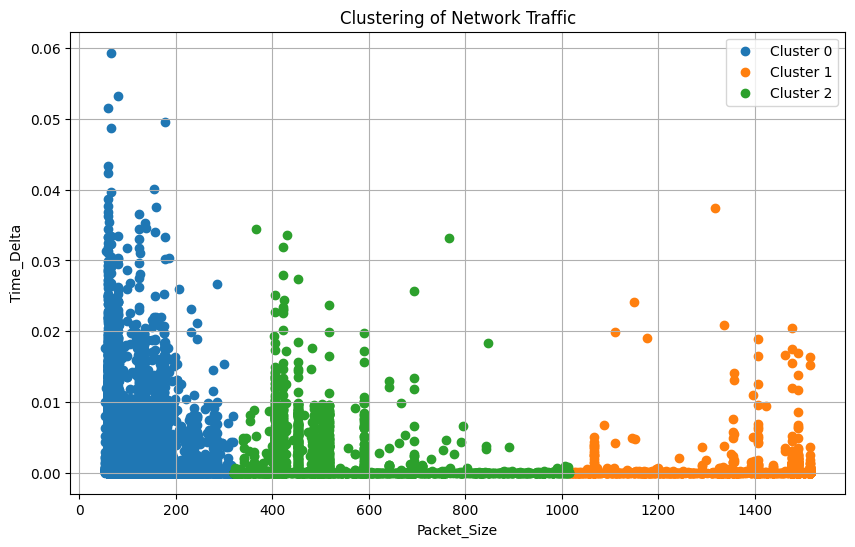

In [ ]:
# Example usage:
# Assuming 'packet_df' contains the DataFrame with packet data and 'features' is a list of selected features
cluster_and_visualize(capture1_df, ['Packet_Size', 'Time_Delta'])


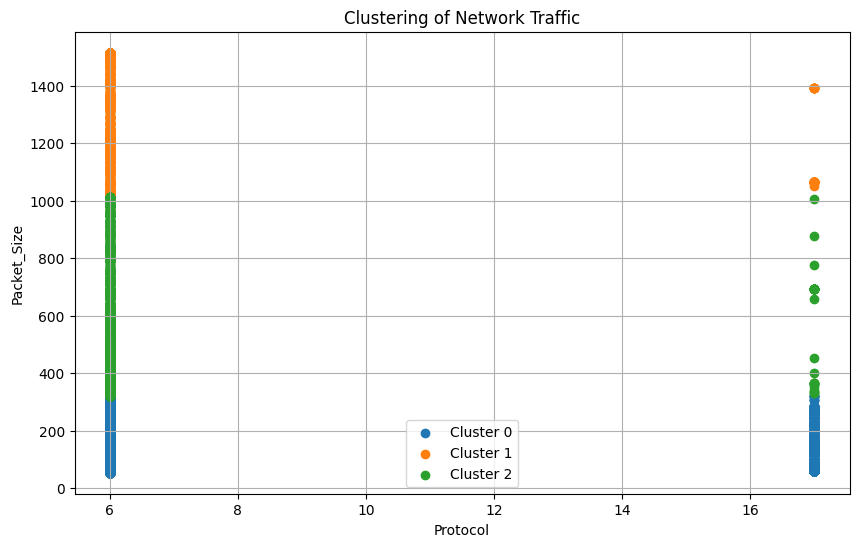

In [ ]:
cluster_and_visualize(capture1_df, ['Protocol', 'Packet_Size'])

### capture 2 

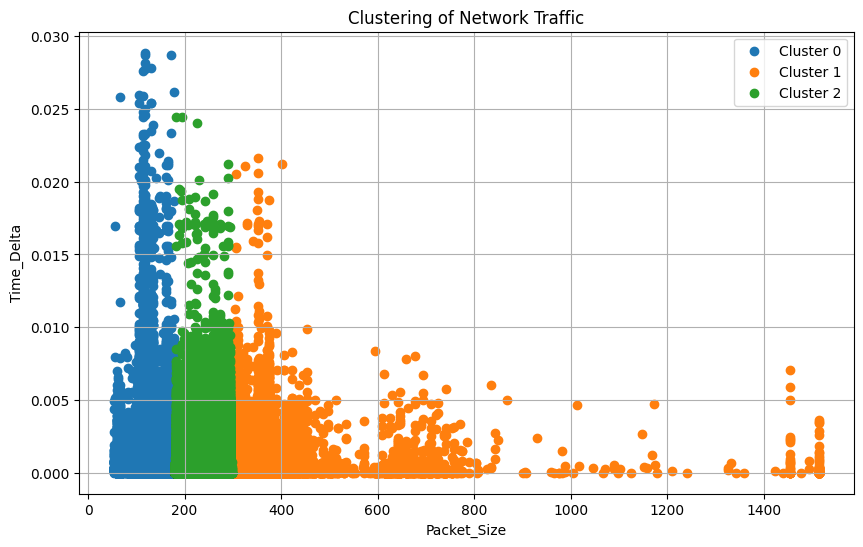

In [ ]:
cluster_and_visualize(capture2_df, ['Packet_Size', 'Time_Delta'])


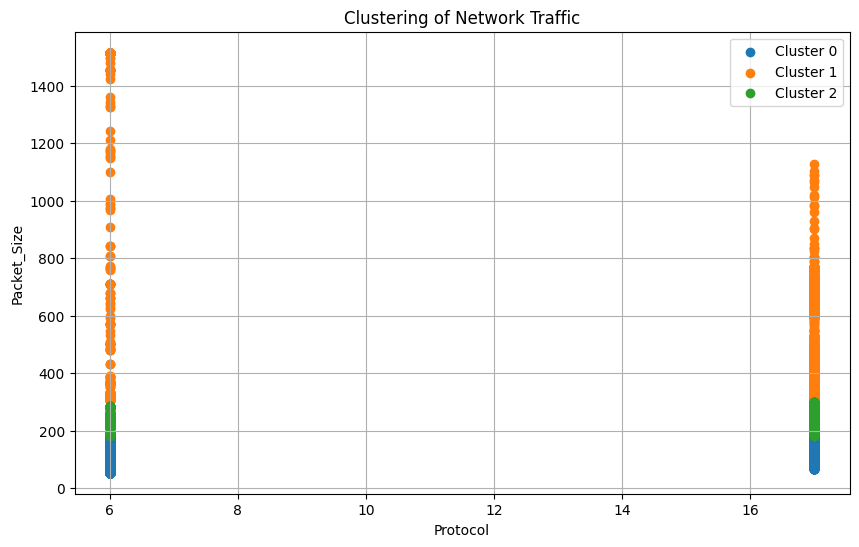

In [ ]:
cluster_and_visualize(capture2_df, ['Protocol', 'Packet_Size'])

## session

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def cluster_and_visualize(session_df, features, n_clusters=3):
    # Select the features for clustering
    X = session_df[features]

    # Apply standardization if necessary
    # (not always required, depends on the clustering algorithm and data distribution)
    # Example:
    # from sklearn.preprocessing import StandardScaler
    # scaler = StandardScaler()
    # X_scaled = scaler.fit_transform(X)

    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    session_df['Cluster'] = kmeans.fit_predict(X)

    # Visualize clusters
    plt.figure(figsize=(10, 6))
    for cluster in session_df['Cluster'].unique():
        cluster_data = session_df[session_df['Cluster'] == cluster]
        plt.scatter(cluster_data[features[0]], cluster_data[features[1]], label=f'Cluster {cluster}')
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.title('Clustering of Sessions')
    plt.legend()
    plt.show()




### session 1

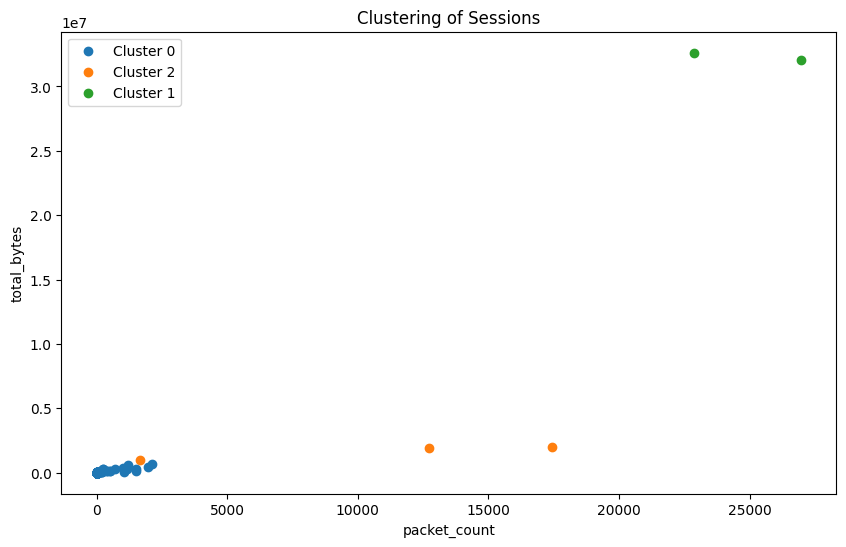

In [ ]:
# Example usage:
# Assuming 'session_df' contains the DataFrame with session data and 'features' is a list of selected features
cluster_and_visualize(capture1_session_info_df, ['packet_count', 'total_bytes'])

In [ ]:
capture1_session_info_df.columns

Index(['packet_count', 'average_packet_size', 'average_time_delta',
       'min_packet_size', 'max_packet_size', 'total_bytes',
       'unique_source_ips', 'unique_destination_ips', 'unique_source_ports',
       'unique_destination_ports', 'most_common_protocol', 'Cluster'],
      dtype='object')

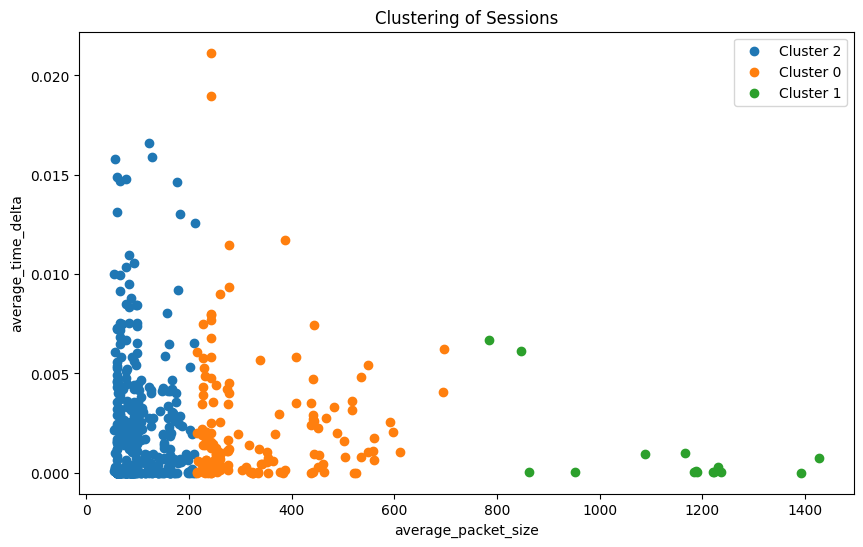

In [ ]:
cluster_and_visualize(capture1_session_info_df, ['average_packet_size', 'average_time_delta'])

### session 2

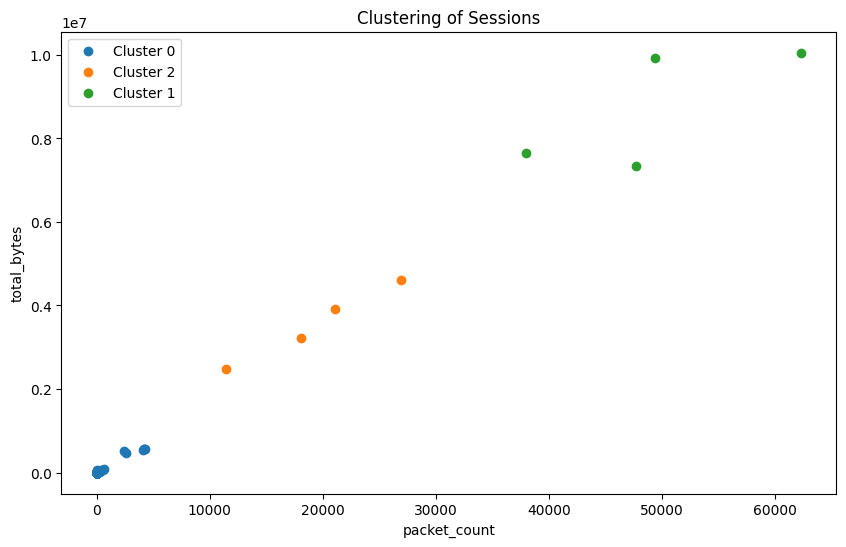

In [ ]:
cluster_and_visualize(capture2_session_info_df, ['packet_count', 'total_bytes'])

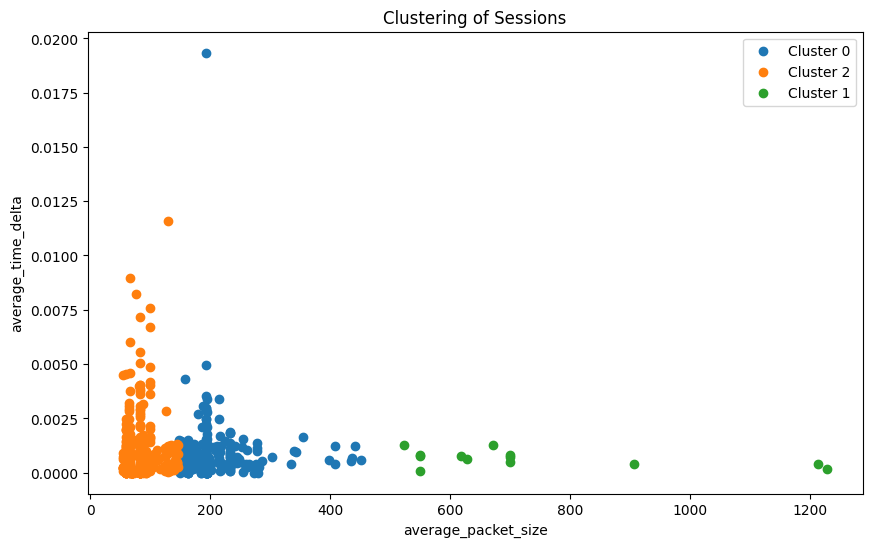

In [ ]:
cluster_and_visualize(capture2_session_info_df, ['average_packet_size', 'average_time_delta'])

# Detection d'anomalie

## Detect on session

In [44]:
test.shape

(555, 12)

In [45]:
train.shape

(597, 12)

In [47]:
train['anomalie'].value_counts()

anomalie
0    521
1     76
Name: count, dtype: int64

In [48]:
test['anomalie'].value_counts()

anomalie
0    536
1     19
Name: count, dtype: int64

In [57]:
train.head()

packet_count  \
0.0.0.0      255.255.255.255 68.0   67.0    17.0             6   
10.200.0.130 105.159.18.7    4500.0 4500.0  17.0           205   
             119.39.240.90   4500.0 50293.0 17.0           172   
             128.92.92.124   4500.0 27012.0 17.0           225   
                                    39024.0 17.0           123   

                                                  average_packet_size  \
0.0.0.0      255.255.255.255 68.0   67.0    17.0           342.000000   
10.200.0.130 105.159.18.7    4500.0 4500.0  17.0           144.341463   
             119.39.240.90   4500.0 50293.0 17.0           124.232558   
             128.92.92.124   4500.0 27012.0 17.0           138.124444   
                                    39024.0 17.0           125.869919   

                                                  average_time_delta  \
0.0.0.0      255.255.255.255 68.0   67.0    17.0            0.000957   
10.200.0.130 105.159.18.7    4500.0 4500.0  17.0            0.000330   
             119.39.240.90   4500.0 50293.0 17.0            0.000304   
             128.92.92.124   4500.0 27012.0 17.0            0.000243   
                                    39024.0 17.0            0.000213   

                                                  min_packet_size  \
0.0.0.0      255.255.255.255 68.0   67.0    17.0              342   
10.200.0.130 105.159.18.7    4500.0 4500.0  17.0              102   
             119.39.240.90   4500.0 50293.0 17.0              106   
             128.92.92.124   4500.0 27012.0 17.0               98   
                                    39024.0 17.0              118   

                                                  max_packet_size  \
0.0.0.0      255.255.255.255 68.0   67.0    17.0              342   
10.200.0.130 105.159.18.7    4500.0 4500.0  17.0              290   
             119.39.240.90   4500.0 50293.0 17.0              158   
             128.92.92.124   4500.0 27012.0 17.0              270   
                                    39024.0 17.0              158   

                                                  total_bytes  \
0.0.0.0      255.255.255.255 68.0   67.0    17.0         2052   
10.200.0.130 105.159.18.7    4500.0 4500.0  17.0        29590   
             119.39.240.90   4500.0 50293.0 17.0        21368   
             128.92.92.124   4500.0 27012.0 17.0        31078   
                                    39024.0 17.0        15482   

                                                  unique_source_ips  \
0.0.0.0      255.255.255.255 68.0   67.0    17.0                  1   
10.200.0.130 105.159.18.7    4500.0 4500.0  17.0                  1   
             119.39.240.90   4500.0 50293.0 17.0                  1   
             128.92.92.124   4500.0 27012.0 17.0                  1   
                                    39024.0 17.0                  1   

                                                  unique_destination_ips  \
0.0.0.0      255.255.255.255 68.0   67.0    17.0                       1   
10.200.0.130 105.159.18.7    4500.0 4500.0  17.0                       1   
             119.39.240.90   4500.0 50293.0 17.0                       1   
             128.92.92.124   4500.0 27012.0 17.0                       1   
                                    39024.0 17.0                       1   

                                                  unique_source_ports  \
0.0.0.0      255.255.255.255 68.0   67.0    17.0                    1   
10.200.0.130 105.159.18.7    4500.0 4500.0  17.0                    1   
             119.39.240.90   4500.0 50293.0 17.0                    1   
             128.92.92.124   4500.0 27012.0 17.0                    1   
                                    39024.0 17.0                    1   

                                                  unique_destination_ports  \
0.0.0.0      255.255.255.255 68.0   67.0    17.0                         1   
10.200.0.130 105.159.18.7    4500.0 4500.0  17.0                         1   
   

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=2000, n_jobs=-1),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier()
}

# Define features and target variable for train and test DataFrames
X_train = train.drop(columns=['anomalie'])  # Features for train DataFrame
y_train = train['anomalie']  # Target variable for train DataFrame

X_test = test.drop(columns=['anomalie'])  # Features for test DataFrame
y_test = test['anomalie']  # Target variable for test DataFrame

# Iterate over each model
for model_name, model in models.items():
    print(f'========================= Model: {model_name} =========================')
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions
    predictions = model.predict(X_test)
    
    # Classification report
    report = classification_report(y_test, predictions)
    print(report)


========================= Model: Logistic Regression =========================
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       536
           1       1.00      0.05      0.10        19

    accuracy                           0.97       555
   macro avg       0.98      0.53      0.54       555
weighted avg       0.97      0.97      0.95       555

========================= Model: SVM =========================


C:\Users\idris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\idris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\idris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classificati

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       536
           1       0.00      0.00      0.00        19

    accuracy                           0.97       555
   macro avg       0.48      0.50      0.49       555
weighted avg       0.93      0.97      0.95       555

========================= Model: Random Forest =========================
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       536
           1       0.38      0.47      0.42        19

    accuracy                           0.95       555
   macro avg       0.68      0.72      0.70       555
weighted avg       0.96      0.95      0.96       555

